<h1> Data Analysis to understand how different factors have affected US house prices over the last 20 years <h1>

## Data Gathering

<h4>
In order to understand how US house prices have been affected over the past 20 years, we gather data for the following factors
<li>Interest Rate</li>
<li>Mortgage Interest Rate</li>
<li>Economic Cost Index</li>
<li>Employee Salaries</li>
<li>GDP</li>
<li>Supply of New Houses</li>
<li>Population Growth</li>
<li>Unemployment Rate</li>
The data is collected from this site
<a href="https://fred.stlouisfed.org/">Federal Reserve Bank</a>
</h4>

In [2]:
import pandas as pd
import os
from functools import reduce

In [3]:
def basic_preprocessing(filepath, rename_column_map={}):
  df = pd.read_csv(filepath)
  if rename_column_map:
    df = df.rename(columns=rename_column_map)
  return df

def filter_dates(df, starting_date):
  df = df[df['DATE']>=starting_date]
  return df


def eda_for_dates(all_dfs):
  eda_df = []
  for each_df in all_dfs:
    eda_df.append([each_df["DATE"].nunique(), sorted(each_df["DATE"].unique())[0], type(each_df["DATE"].unique()[0])])

  print(pd.DataFrame(eda_df, columns=['# unique values','date sample','date dtype']))

<h4>We are using the S&P Case-Schiller Home Price Index value as a proxy for the house price value</h4>

In [4]:
target_df = basic_preprocessing("data/Home_Price_Index.csv", {"CSUSHPISA":"Home_Price_Index"})

<h4>Let's give some descriptive names to the columns</h4>

In [5]:
eco_df = basic_preprocessing("data/Economic_Cost_Index_Wages_and_Salaries.csv", {"ECICONWAG":"Employment_Cost_Index"})
emp_df = basic_preprocessing("data/Employee_Salaries.csv", {"A576RC1":"Median_Weekly_Wage_in_dollars"})
gdp_df = basic_preprocessing("data/GDP.csv", {"NGDPRSAXDCUSQ":"GDP"})
m_df = basic_preprocessing("data/MORTGAGE30US.csv", {"MORTGAGE30US":"Mortgage_Rate"})
monthly_house_sale_df = basic_preprocessing("data/Monthly_Supply_New_Houses_US.csv", {"MSACSR":"Monthly_Supply_House"})
pop_df = basic_preprocessing("data/Population_Growth_US.csv", {"SPPOPGROWUSA":"Population_Growth"})
unemp_df = basic_preprocessing("data/Unemployment_Rate.csv", {"UNRATE":"Unemployment_Rate"})

int_df_1 = basic_preprocessing("data/interest_rates_monthly_1.csv", {"INTDSRUSM193N":"Monthly_Interest_Rate"})
int_df_2 = basic_preprocessing("data/interest_rates_monthly_2.csv", {"30-Day AA Financial Commercial Paper Interest Rate":"Monthly_Interest_Rate", "Series Description":"DATE"})

In [6]:
int_df_1.columns

Index(['DATE', 'Monthly_Interest_Rate'], dtype='object')

In [7]:
int_df_2.columns

Index(['DATE', 'Monthly_Interest_Rate',
       '30-Day AA Nonfinancial Commercial Paper Interest Rate'],
      dtype='object')

In [8]:
int_df_2.head()

,DATE,Monthly_Interest_Rate,30-Day AA Nonfinancial Commercial Paper Interest Rate
0,Unit:,Percent,Percent
1,Multiplier:,1,1
2,Currency:,NaN,NaN
3,Unique Identifier:,H15/H15/RIFSPPFAAD30_N.M,H15/H15/RIFSPPNAAD30_N.M
4,Time Period,RIFSPPFAAD30_N.M,RIFSPPNAAD30_N.M


<h4>These 2 DataFrames have different column names and few unnecessary rows, let's remove them and rename columns to make it easier for merging the DataFrames later on</h4>

In [9]:
int_df_2 = int_df_2.loc[5:,:]
int_df_2 = int_df_2.drop("30-Day AA Nonfinancial Commercial Paper Interest Rate", axis=1)

In [10]:
int_df_2.head()

,DATE,Monthly_Interest_Rate
5,2021-01,0.10
6,2021-02,0.09
7,2021-03,0.08
8,2021-04,0.08
9,2021-05,0.06


<h4>Since the date format for the other factors are in ISO format, let's change it for int_df_2 as well, from YYYY-MM format to YYYY-MM-DD format<h4>

In [11]:
int_df_2.loc[:,'DATE'] = int_df_2.loc[:,'DATE']+'-01'
int_df_2.head()

,DATE,Monthly_Interest_Rate
5,2021-01-01,0.10
6,2021-02-01,0.09
7,2021-03-01,0.08
8,2021-04-01,0.08
9,2021-05-01,0.06


In [12]:
int_df = pd.concat([int_df_1, int_df_2])

In [13]:
int_df

,DATE,Monthly_Interest_Rate
0,1950-01-01,1.5
1,1950-02-01,1.5
2,1950-03-01,1.5
3,1950-04-01,1.5
4,1950-05-01,1.5
...,...,...
35,2023-07-01,5.22
36,2023-08-01,5.37
37,2023-09-01,5.38
38,2023-10-01,5.38


## Data preprocessing

<h2> What range of date values do we have for each factor across the multiple dataframes ? </h2>

In [14]:
all_dfs = [target_df, eco_df, emp_df, gdp_df, m_df, monthly_house_sale_df, unemp_df, int_df, pop_df]
eda_for_dates(all_dfs)

   # unique values date sample     date dtype
0              441  1987-01-01  <class 'str'>
1               91  2001-01-01  <class 'str'>
2              778  1959-01-01  <class 'str'>
3              295  1950-01-01  <class 'str'>
4             2751  1971-04-02  <class 'str'>
5              730  1963-01-01  <class 'str'>
6              911  1948-01-01  <class 'str'>
7              887  1950-01-01  <class 'str'>
8               62  1961-01-01  <class 'str'>


<h4> Here's some observations regarding the dates
<li>We need last 20 years data so our starting date is 2004-01-01 ( 2004 to 2023, 2023 inclusive )</li>
<li>The dates are in ISO format so we can simply sort or compare the dates lexicographically so we don't have to convert to datetime objects just yet</li>
<li>If we have 20 years monthly data then the number of unique dates should be 12*20=240 but some factors have lesser samples like in row 2 it starts from 2001 but has only 91 data points.... we need to handle the missing dates using some suitable interpolation technique</li>
</h4>

In [15]:
all_dfs = [filter_dates(each, '2004-01-01') for each in all_dfs]
eda_for_dates(all_dfs)

   # unique values date sample     date dtype
0              237  2004-01-01  <class 'str'>
1               79  2004-01-01  <class 'str'>
2              238  2004-01-01  <class 'str'>
3               79  2004-01-01  <class 'str'>
4             1041  2004-01-08  <class 'str'>
5              238  2004-01-01  <class 'str'>
6              239  2004-01-01  <class 'str'>
7              239  2004-01-01  <class 'str'>
8               19  2004-01-01  <class 'str'>


<h4>Fixing the missing dates</h4>

In [16]:
def fix_missing_dates(df):
  date_range = pd.date_range(start='2004-01-01', end='2023-12-01', freq='MS')
  all_months_df = pd.DataFrame({'DATE': date_range})
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
  result_df = pd.merge(all_months_df, df, on='DATE', how='left')
  result_df.fillna(method='ffill', inplace=True)
  return result_df



all_dfs = [fix_missing_dates(each) for each in all_dfs]
eda_for_dates(all_dfs)

   # unique values date sample                  date dtype
0              240  2004-01-01  <class 'numpy.datetime64'>
1              240  2004-01-01  <class 'numpy.datetime64'>
2              240  2004-01-01  <class 'numpy.datetime64'>
3              240  2004-01-01  <class 'numpy.datetime64'>
4              240  2004-01-01  <class 'numpy.datetime64'>
5              240  2004-01-01  <class 'numpy.datetime64'>
6              240  2004-01-01  <class 'numpy.datetime64'>
7              240  2004-01-01  <class 'numpy.datetime64'>
8              240  2004-01-01  <class 'numpy.datetime64'>


<ipython-input-16-2796f83bb61c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
<ipython-input-16-2796f83bb61c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
<ipython-input-16-2796f83bb61c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

<h4>Combining all the DataFrames together</h4>

In [17]:
dataset = reduce(lambda x,y: pd.merge(x,y,on=['DATE']), all_dfs)
dataset.head()

,DATE,Home_Price_Index,Employment_Cost_Index,Median_Weekly_Wage_in_dollars,GDP,Mortgage_Rate,Monthly_Supply_House,Unemployment_Rate,Monthly_Interest_Rate,Population_Growth
0,2004-01-01,141.646,95.5,5264.9,3812170.0,NaN,3.8,5.7,2.0,0.925484
1,2004-02-01,143.192,95.5,5267.5,3812170.0,NaN,3.7,5.6,2.0,0.925484
2,2004-03-01,145.059,95.5,5291.1,3812170.0,NaN,3.6,5.8,2.0,0.925484
3,2004-04-01,146.593,95.8,5331.2,3841712.5,5.52,4.0,5.6,2.0,0.925484
4,2004-05-01,148.186,95.8,5395.4,3841712.5,5.52,3.8,5.6,2.0,0.925484


In [18]:
dataset.fillna(method='bfill',inplace=True)

## Exploratory Data Analysis

<h4>Check for missing values</h4>

In [19]:
dataset.isnull().sum()

DATE                             0
Home_Price_Index                 0
Employment_Cost_Index            0
Median_Weekly_Wage_in_dollars    0
GDP                              0
Mortgage_Rate                    0
Monthly_Supply_House             0
Unemployment_Rate                0
Monthly_Interest_Rate            0
Population_Growth                0
dtype: int64

In [20]:
dataset.columns

Index(['DATE', 'Home_Price_Index', 'Employment_Cost_Index',
       'Median_Weekly_Wage_in_dollars', 'GDP', 'Mortgage_Rate',
       'Monthly_Supply_House', 'Unemployment_Rate', 'Monthly_Interest_Rate',
       'Population_Growth'],
      dtype='object')

<h4>
<li>The scale of values for different factors are different so we apply min-max normalization for feature scaling</li>
<li>Feature scaling ensures gradient descent converges faster</li>
<li>Feature scaling also helps to assign weights irrespective of the scale of the features</li>
</h4>

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()

columns = ['Home_Price_Index', 'Employment_Cost_Index',
       'Median_Weekly_Wage_in_dollars', 'GDP', 'Mortgage_Rate',
       'Monthly_Supply_House', 'Unemployment_Rate', 'Monthly_Interest_Rate',
       'Population_Growth']
for each_column in columns:
    dataset[each_column] = scaler.fit_transform(dataset.loc[:,each_column].values.reshape(-1,1))

<h4>Let's check what is the correlation between our target variable ( Home_Price_Index ) and the feature variables</h4>

In [22]:
dataset.corr()

<ipython-input-22-c187c74d1e71>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,Home_Price_Index,Employment_Cost_Index,Median_Weekly_Wage_in_dollars,GDP,Mortgage_Rate,Monthly_Supply_House,Unemployment_Rate,Monthly_Interest_Rate,Population_Growth
Home_Price_Index,1.000000,0.869406,0.910894,0.866927,-0.136127,0.109500,-0.545471,0.185858,-0.712607
Employment_Cost_Index,0.869406,1.000000,0.990340,0.977827,-0.436629,0.043388,-0.312479,-0.183399,-0.804511
Median_Weekly_Wage_in_dollars,0.910894,0.990340,1.000000,0.988049,-0.397151,0.016179,-0.427346,-0.098469,-0.813074
GDP,0.866927,0.977827,0.988049,1.000000,-0.468775,-0.049754,-0.457363,-0.134527,-0.827709
Mortgage_Rate,-0.136127,-0.436629,-0.397151,-0.468775,1.000000,0.440009,-0.134649,0.760219,0.486675
Monthly_Supply_House,0.109500,0.043388,0.016179,-0.049754,0.440009,1.000000,0.018634,0.210645,0.076521
Unemployment_Rate,-0.545471,-0.312479,-0.427346,-0.457363,-0.134649,0.018634,1.000000,-0.528931,0.345667
Monthly_Interest_Rate,0.185858,-0.183399,-0.098469,-0.134527,0.760219,0.210645,-0.528931,1.000000,0.232801
Population_Growth,-0.712607,-0.804511,-0.813074,-0.827709,0.486675,0.076521,0.345667,0.232801,1.000000


<h4> Observations
<li>Home_Price_Index has high positive correlation with Employment_Cost_Index and Median_Weekly_Wage_in_dollars which means over the past 20 years as cost of employees / salary of workers increased, the price of houses also increased</li>
<li>Similarly, as GDP increased, home price also increased </li>
<li>Monthly_Interest_Rate has low positive correlation with house price, as interest rates increase, house price also increases but not linearly</li>
<li>Mortgage_Rate is negatively correlated with house price. One way to explain it is if mortgage rate is high, people with mortgages might have to opt to sell their houses, causing increase in house supply and that can cause drop in house price</li>
<li>Monthly Supply House is weakly positively correlated with house price</li>
<li>Unemployment rate is negatively correlated with house price, as unemployment rate reduced, house prices increased ( expected )</li>
<li>Population growth is highly negatively correlated with house price, as population dropped house prices went on increasing ( possibly population doesn't influence house prices much )</li>
</h4>

In [23]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

def plot_graph_with_time(dataset, y_columns):
    x_axis_val = [x for x in range(1, len(dataset)+1)]
    x_axis_labels = [ np.datetime_as_string(each, unit='s').split("T")[0] for each in dataset['DATE'].values ]
    for each_column in y_columns:
        y_axis_val = dataset[each_column].values
        plt.plot(x_axis_val[0:len(x_axis_val):10], y_axis_val[0:len(y_axis_val):10])
    plt.xticks(x_axis_val[0:len(x_axis_val):10], x_axis_labels[0:len(x_axis_labels):10], rotation='vertical')
    plt.legend(y_columns)
    plt.xlabel('Time')
    plt.show()



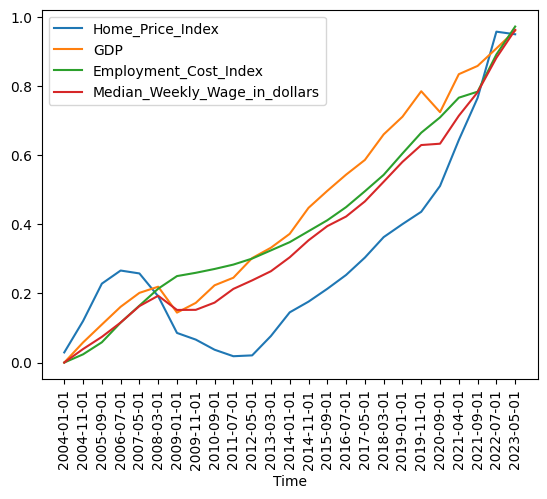

In [24]:
plot_graph_with_time(dataset, ['Home_Price_Index', 'GDP',\
                    'Employment_Cost_Index', 'Median_Weekly_Wage_in_dollars' ])

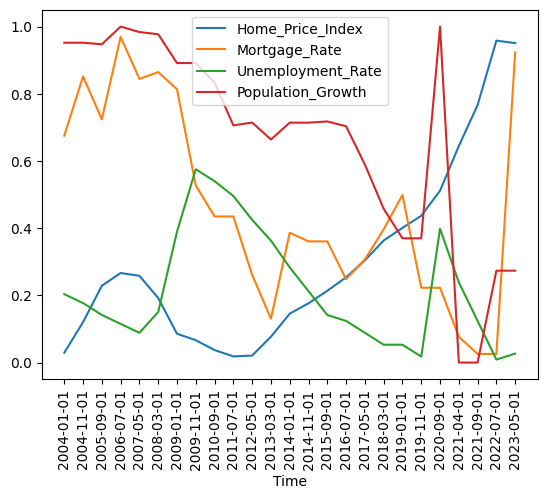

In [25]:
plot_graph_with_time(dataset, ['Home_Price_Index', 'Mortgage_Rate',\
                               'Unemployment_Rate','Population_Growth'])

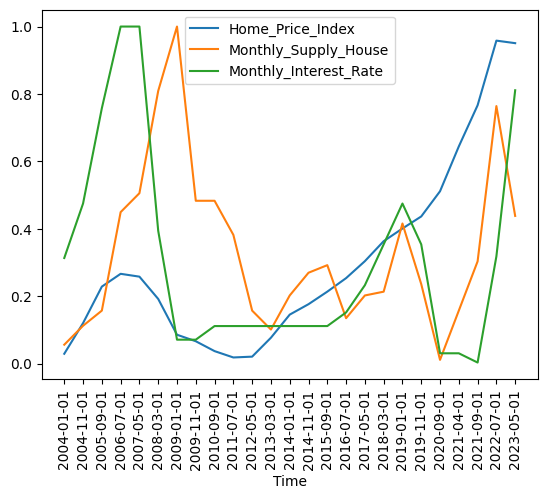

In [26]:
plot_graph_with_time(dataset, ['Home_Price_Index', 'Monthly_Supply_House',\
                               'Monthly_Interest_Rate'])

## Model building

<h4>
<li>We will build a linear regression model which will predict the home price index based on the features like GDP, Mortgage rate etc</li>
<li>Two important assumptions of linear regression models are - target variable must be normally distributed and the feature variables must be independant of each other</li>
<li>From the correlation matrix we can see that GDP, Employment_Cost_Index, Median_Weekly_Wage_in_dollars are highly positively correlated (>0.8). This means out of these 3 we can take only 1 of them as input feature during model building, taking the one with highest correlation with Home_Price_Index</li>
<li>Similarly, population growth is highly negatively correlated with median weekly wage so either one of them can be selected</li>
</h4>

<h4>Features selected for model building
<li>Median_Weekly_Wage_in_dollars	</li>
<li>Mortgage_Rate</li>
<li>Monthly_Supply_House</li>
<li>Unemployment_Rate</li>
<li>Monthly_Interest_Rate</li>
</h4>

<h4>Check the distribution of the target variable</h4>

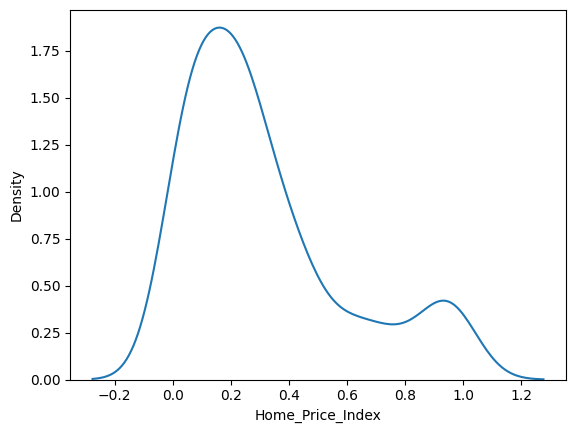

In [34]:
import seaborn as sns
sns.kdeplot(dataset['Home_Price_Index'])
plt.show()

<h4>Not ideal normal distribution but good enough for our purposes</h4>

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
features = ['Median_Weekly_Wage_in_dollars','Mortgage_Rate',
       'Monthly_Supply_House', 'Unemployment_Rate', 'Monthly_Interest_Rate']
X = dataset[features]
Y = dataset['Home_Price_Index']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

train_predictions = linear_regressor.predict(X_train)
test_predictions = linear_regressor.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

train_r2_score_val = r2_score(y_train, train_predictions)
train_adjusted_r2_score_val = 1-((1-train_r2_score_val)*(len(y_train)-1))/(len(y_train)-1-len(features))

test_r2_score_val = r2_score(y_test, test_predictions)
test_adjusted_r2_score_val = 1-((1-test_r2_score_val)*(len(y_test)-1))/(len(y_test)-1-len(features))


pd.DataFrame(data=[[test_adjusted_r2_score_val,  \
train_adjusted_r2_score_val,train_rmse, test_rmse]], \
columns=['Test_Adjusted_r2_score','Train_Adjusted_r2_score','Train_RMSE','Test_RMSE'])




,Test_Adjusted_r2_score,Train_Adjusted_r2_score,Train_RMSE,Test_RMSE
0,0.897765,0.903803,0.082377,0.091189


In [51]:
weights = linear_regressor.coef_
bias = linear_regressor.intercept_
for each_feature, each_weight in zip(features, weights):
      print("Feature = {} is assigned a weight of {}".format(each_feature, each_weight))


Feature = Median_Weekly_Wage_in_dollars is assigned a weight of 0.9949431176604931
Feature = Mortgage_Rate is assigned a weight of 0.0399073183675555
Feature = Monthly_Supply_House is assigned a weight of 0.05259025882045174
Feature = Unemployment_Rate is assigned a weight of -0.03479127188293256
Feature = Monthly_Interest_Rate is assigned a weight of 0.21082725861768056


##Results and conclusion

<h4>
<li>Linear regression model built with the selected features achieves adjusted r2 score of 0.89 on test data</li>
<li>RMSE loss on test data is 0.09</li>
</h4>